In [1]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"username","key":"key"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

In [2]:
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

 99% 147M/149M [00:04<00:00, 40.4MB/s]
100% 149M/149M [00:04<00:00, 32.3MB/s]


In [3]:
!unzip -qq brain-tumor-mri-dataset.zip 

In [4]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from PIL import Image
import torchvision
import torch.nn as nn
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import torch
import os
import time
import random
from tqdm import tqdm
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
from torchvision import datasets, transforms, models
from torchvision import transforms as transforms
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler
%matplotlib inline

In [5]:
glioma_pt = 'Training/glioma'
meningioma_pt = 'Training/meningioma'
notumor_pt = 'Training/notumor'
pituitary_pt = 'Training/pituitary'
data_dir = 'Training'

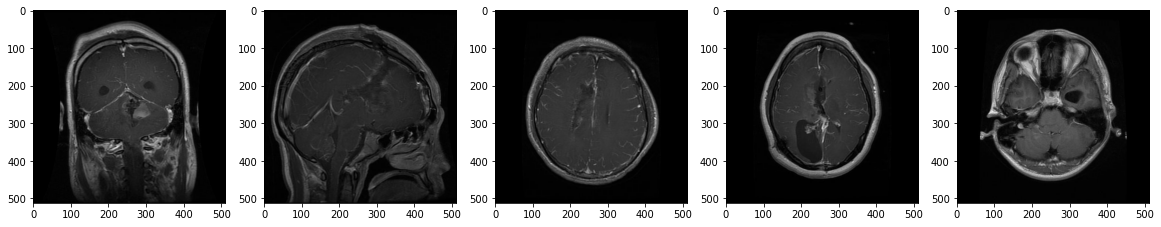

In [ ]:
glioma_files      = [os.path.join(glioma_pt , x) for x in os.listdir(glioma_pt)]
glioma_images    =  [cv2.imread(x) for x in random.sample(glioma_files , 5)]

plt.figure(figsize=(20,10))
columns = 5
for i, image in enumerate(glioma_images):
    plt.subplot(len(glioma_images) / columns + 1, columns, i + 1)
    plt.imshow(image)

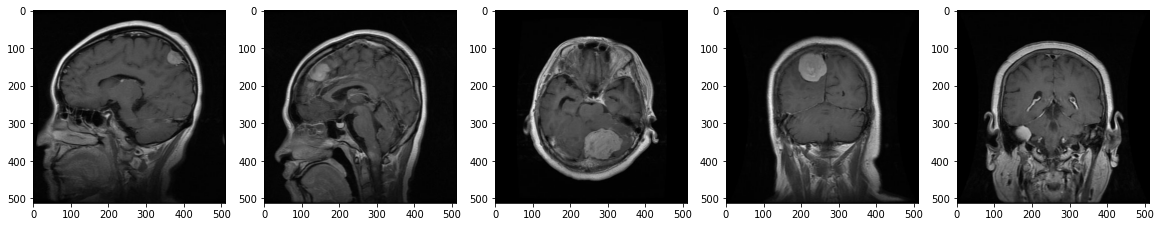

In [ ]:
meningioma_files      = [os.path.join(meningioma_pt , x) for x in os.listdir(meningioma_pt)]
meningioma_images    =  [cv2.imread(x) for x in random.sample(meningioma_files , 5)]

plt.figure(figsize=(20,10))
columns = 5
for i, image in enumerate(meningioma_images):
    plt.subplot(len(meningioma_images) / columns + 1, columns, i + 1)
    plt.imshow(image)

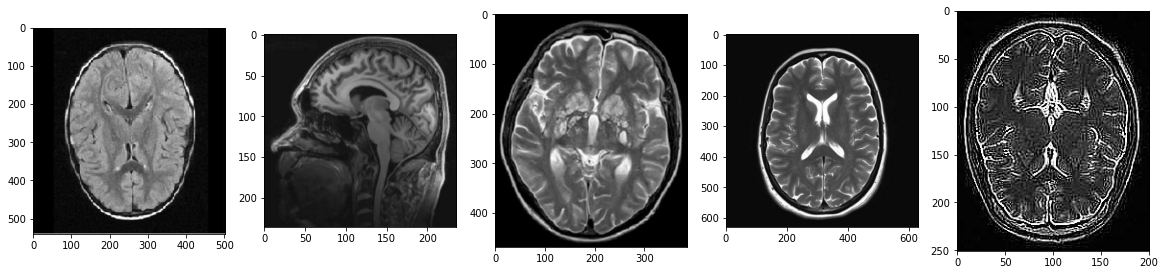

In [ ]:
notumor_files      = [os.path.join(notumor_pt , x) for x in os.listdir(notumor_pt)]
notumor_images    =  [cv2.imread(x) for x in random.sample(notumor_files , 5)]

plt.figure(figsize=(20,10))
columns = 5
for i, image in enumerate(notumor_images):
    plt.subplot(len(notumor_images) / columns + 1, columns, i + 1)
    plt.imshow(image)

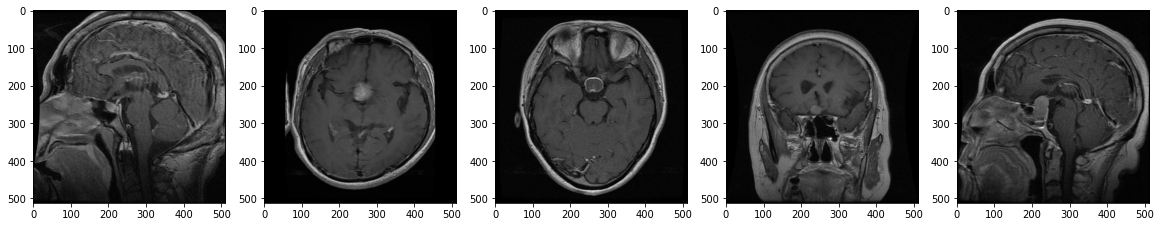

In [ ]:
pituitary_files      = [os.path.join(pituitary_pt , x) for x in os.listdir(pituitary_pt)]
pituitary_images    =  [cv2.imread(x) for x in random.sample(pituitary_files , 5)]

plt.figure(figsize=(20,10))
columns = 5
for i, image in enumerate(pituitary_images):
    plt.subplot(len(pituitary_images) / columns + 1, columns, i + 1)
    plt.imshow(image)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")     

In [7]:
print(device)

cuda


In [8]:
def load_split_train_test(datadir, valid_size = .2):
    train_transforms = transforms.Compose([transforms.Resize((300,300)),
                                       transforms.ToTensor(),
                                       ])
    test_transforms = transforms.Compose([transforms.Resize((300, 300)),
                                      transforms.ToTensor(),
                                      ])
    train_data = datasets.ImageFolder(datadir,       
                    transform=train_transforms)
    test_data = datasets.ImageFolder(datadir,
                    transform=test_transforms)
    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)
    
    train_idx, test_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)
    trainloader = torch.utils.data.DataLoader(train_data,
                   sampler=train_sampler, batch_size=64)
    testloader = torch.utils.data.DataLoader(test_data,
                   sampler=test_sampler, batch_size=64)
    return trainloader, testloader
trainloader, testloader = load_split_train_test(data_dir, .2)
print(trainloader.dataset.classes)

['glioma', 'meningioma', 'notumor', 'pituitary']


In [15]:
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']

In [18]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [19]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(testloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
model = models.resnet50(pretrained=True)
print(model)

In [ ]:
model.fc = nn.Sequential(nn.Linear(2048, 512), #overwrite on the model's fully connected(fc) layer
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, 4),
                                 nn.LogSoftmax(dim=1))
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)
model.to(device)

In [11]:
# defining the optimizer
optimizer = Adam(model.parameters(), lr=0.07)
# defining the loss function
criterion = CrossEntropyLoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

In [ ]:
print(model)

In [12]:
epochs = 20
steps = 0
running_loss = 0
print_every = 10
train_losses, test_losses = [], []
for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device),labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    test_loss += batch_loss.item()
                    
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals =  top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader))                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            model.train()
torch.save(model, 'brain_model.pth')

Epoch 1/20.. Train loss: 53.325.. Test loss: 616693972981164672.000.. Test accuracy: 0.278
Epoch 1/20.. Train loss: 4.452.. Test loss: 6417505728739.556.. Test accuracy: 0.241
Epoch 1/20.. Train loss: 1.496.. Test loss: 2174953422.222.. Test accuracy: 0.241
Epoch 1/20.. Train loss: 1.316.. Test loss: 5994246.250.. Test accuracy: 0.279
Epoch 1/20.. Train loss: 1.377.. Test loss: 18580.958.. Test accuracy: 0.285
Epoch 1/20.. Train loss: 1.022.. Test loss: 43.025.. Test accuracy: 0.322
Epoch 1/20.. Train loss: 1.023.. Test loss: 1.695.. Test accuracy: 0.465
Epoch 2/20.. Train loss: 0.983.. Test loss: 1.039.. Test accuracy: 0.612
Epoch 2/20.. Train loss: 0.905.. Test loss: 0.870.. Test accuracy: 0.664
Epoch 2/20.. Train loss: 0.977.. Test loss: 1.002.. Test accuracy: 0.654
Epoch 2/20.. Train loss: 0.904.. Test loss: 0.924.. Test accuracy: 0.663
Epoch 2/20.. Train loss: 0.859.. Test loss: 0.894.. Test accuracy: 0.679
Epoch 2/20.. Train loss: 0.867.. Test loss: 0.808.. Test accuracy: 0.701
E

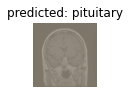

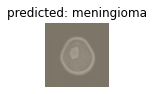

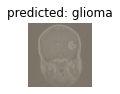

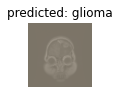

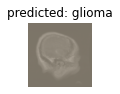

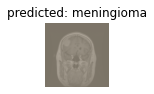

In [20]:
visualize_model(model)

In [21]:
model_tl = models.resnet50(pretrained=True)

In [22]:
i=0
for param in model_tl.parameters():
    if i<=4:
      param.requires_grad = False
    i+=1

In [ ]:
model_tl.fc = nn.Sequential(nn.Linear(2048, 512), #overwrite on the model's fully connected(fc) layer
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, 4),
                                 nn.LogSoftmax(dim=1))
criterion = nn.NLLLoss()
optimizer = optim.Adam(model_tl.fc.parameters(), lr=0.003)
model_tl.to(device)

In [24]:
# defining the optimizer
optimizer = Adam(model_tl.parameters(), lr=0.07)
# defining the loss function
criterion = CrossEntropyLoss()
# checking if GPU is available
if torch.cuda.is_available():
    model_tl = model_tl.cuda()
    criterion = criterion.cuda()

In [25]:
epochs = 20
steps = 0
running_loss = 0
print_every = 10
train_losses, test_losses = [], []
for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logps = model_tl.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model_tl.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device),labels.to(device)
                    logps = model_tl.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    test_loss += batch_loss.item()
                    
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals =  top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader))                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            model_tl.train()
torch.save(model_tl, 'brain_model_tl.pth')

Epoch 1/20.. Train loss: 21.347.. Test loss: 346862969483107456.000.. Test accuracy: 0.278
Epoch 1/20.. Train loss: 2.510.. Test loss: 7591918563.556.. Test accuracy: 0.279
Epoch 1/20.. Train loss: 17.864.. Test loss: 14834012.667.. Test accuracy: 0.278
Epoch 1/20.. Train loss: 1.268.. Test loss: 724934.920.. Test accuracy: 0.279
Epoch 1/20.. Train loss: 1.182.. Test loss: 73.744.. Test accuracy: 0.279
Epoch 1/20.. Train loss: 1.308.. Test loss: 5.964.. Test accuracy: 0.281
Epoch 1/20.. Train loss: 1.006.. Test loss: 1.522.. Test accuracy: 0.346
Epoch 2/20.. Train loss: 1.004.. Test loss: 1.047.. Test accuracy: 0.581
Epoch 2/20.. Train loss: 0.980.. Test loss: 1.228.. Test accuracy: 0.450
Epoch 2/20.. Train loss: 298.732.. Test loss: 272741147.556.. Test accuracy: 0.278
Epoch 2/20.. Train loss: 2.242.. Test loss: 131390623.111.. Test accuracy: 0.279
Epoch 2/20.. Train loss: 10.373.. Test loss: 65983.855.. Test accuracy: 0.280
Epoch 2/20.. Train loss: 1.366.. Test loss: 12.073.. Test ac

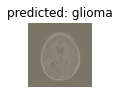

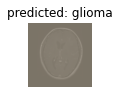

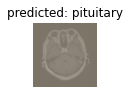

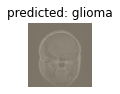

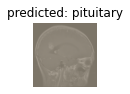

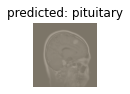

In [27]:
visualize_model(model_tl)